# Notebook 2: 전통 RL - Q-learning과 SARSA

## 🎯 학습 목표
- Model-free 강화학습 이해
- Temporal Difference (TD) 학습 구현
- Q-learning과 SARSA 알고리즘 마스터
- On-policy vs Off-policy 차이 이해
- 실제 에이전트 훈련 및 평가

## 1. Model-free 강화학습

### Model-based vs Model-free

**Model-based (이전 노트북)**
- 환경의 전이 확률 P(s'|s,a)를 알고 있음
- 동적 프로그래밍으로 최적 정책 계산
- 예: Value Iteration, Policy Iteration

**Model-free (이번 노트북)**
- 환경 모델을 모름
- 경험(experience)으로부터 직접 학습
- 예: Q-learning, SARSA, Monte Carlo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, deque
from typing import Tuple, List, Dict, Optional
from dataclasses import dataclass
from enum import Enum
import random
from tqdm import tqdm

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Q-learning과 SARSA 학습 환경 준비 완료!")

Q-learning과 SARSA 학습 환경 준비 완료!


## 2. 환경 구축: 미로 탐험

열쇠를 찾아 문을 열고 목표에 도달하는 미로 환경을 구축합니다.

In [2]:
class Action(Enum):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3

class MazeEnv:
    """미로 환경"""
    
    def __init__(self, maze_type='simple'):
        self.maze_type = maze_type
        self.reset()
        
    def _create_maze(self):
        """미로 생성"""
        if self.maze_type == 'simple':
            # 5x5 간단한 미로
            self.maze = [
                ['S', '.', '.', '.', '.'],
                ['.', '#', '#', '#', '.'],
                ['.', '.', '.', '.', '.'],
                ['.', '#', '#', '#', '.'],
                ['.', '.', '.', '.', 'G']
            ]
            self.start = (0, 0)
            self.goal = (4, 4)
            self.key_pos = None
            self.door_pos = None
            
        elif self.maze_type == 'key_door':
            # 7x7 열쇠-문 미로
            self.maze = [
                ['S', '.', '#', '.', '.', '.', '.'],
                ['.', '.', '#', '.', '#', '#', '.'],
                ['.', '.', '#', '.', '#', 'K', '.'],
                ['.', '.', 'D', '.', '#', '#', '.'],
                ['.', '.', '#', '.', '.', '.', '.'],
                ['.', '.', '#', '#', '#', '.', '.'],
                ['.', '.', '.', '.', '.', '.', 'G']
            ]
            self.start = (0, 0)
            self.goal = (6, 6)
            self.key_pos = (2, 5)
            self.door_pos = (3, 2)
            
        self.height = len(self.maze)
        self.width = len(self.maze[0])
    
    def reset(self):
        """환경 초기화"""
        self._create_maze()
        self.agent_pos = self.start
        self.has_key = False
        self.steps = 0
        self.max_steps = self.height * self.width * 4
        return self._get_state()
    
    def _get_state(self):
        """현재 상태 반환"""
        # 상태 = (위치, 열쇠 소지 여부)
        return (self.agent_pos[0], self.agent_pos[1], int(self.has_key))
    
    def step(self, action: Action):
        """행동 수행"""
        self.steps += 1
        
        # 행동에 따른 이동
        y, x = self.agent_pos
        if action == Action.UP:
            new_pos = (y-1, x)
        elif action == Action.DOWN:
            new_pos = (y+1, x)
        elif action == Action.LEFT:
            new_pos = (y, x-1)
        elif action == Action.RIGHT:
            new_pos = (y, x+1)
        
        # 이동 가능 확인
        if self._is_valid_move(new_pos):
            self.agent_pos = new_pos
        
        # 열쇠 획득
        if self.key_pos and self.agent_pos == self.key_pos and not self.has_key:
            self.has_key = True
        
        # 보상 계산
        reward = self._get_reward()
        
        # 종료 조건
        done = (self.agent_pos == self.goal) or (self.steps >= self.max_steps)
        
        return self._get_state(), reward, done, {}
    
    def _is_valid_move(self, pos):
        """이동 가능 여부 확인"""
        y, x = pos
        
        # 경계 확인
        if y < 0 or y >= self.height or x < 0 or x >= self.width:
            return False
        
        # 벽 확인
        if self.maze[y][x] == '#':
            return False
        
        # 문 확인 (열쇠 없으면 통과 불가)
        if self.door_pos and pos == self.door_pos and not self.has_key:
            return False
        
        return True
    
    def _get_reward(self):
        """보상 반환"""
        if self.agent_pos == self.goal:
            return 100.0  # 목표 도달
        elif self.key_pos and self.agent_pos == self.key_pos and self.has_key:
            return 10.0  # 열쇠 획득
        else:
            return -1.0  # 각 스텝마다 패널티
    
    def render(self):
        """환경 시각화"""
        display = []
        for y in range(self.height):
            row = []
            for x in range(self.width):
                if (y, x) == self.agent_pos:
                    row.append('A')
                elif self.maze[y][x] == 'K' and not self.has_key:
                    row.append('K')
                elif self.maze[y][x] == 'D':
                    row.append('D' if not self.has_key else '.')
                else:
                    row.append(self.maze[y][x])
            display.append(' '.join(row))
        
        print('\n'.join(display))
        if self.has_key:
            print("🔑 열쇠 보유 중")

# 환경 테스트
env = MazeEnv('simple')
print("간단한 미로:")
env.render()

env = MazeEnv('key_door')
print("\n열쇠-문 미로:")
env.render()

간단한 미로:
A . . . .
. # # # .
. . . . .
. # # # .
. . . . G

열쇠-문 미로:
A . # . . . .
. . # . # # .
. . # . # K .
. . D . # # .
. . # . . . .
. . # # # . .
. . . . . . G


## 3. Temporal Difference (TD) 학습

TD 학습은 **현재 추정값**과 **다음 추정값**의 차이를 이용해 학습합니다.

### TD Error
$$\delta_t = r_{t+1} + \gamma V(s_{t+1}) - V(s_t)$$

### TD Update
$$V(s_t) \leftarrow V(s_t) + \alpha \cdot \delta_t$$

여기서 α는 학습률(learning rate)입니다.

/Users/gd452/Development/my-llm-lab/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gd452/Development/my-llm-lab/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53468 (\N{HANGUL SYLLABLE TAE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gd452/Development/my-llm-lab/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gd452/Development/my-llm-lab/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gd452/Development/my-llm-lab/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: Us

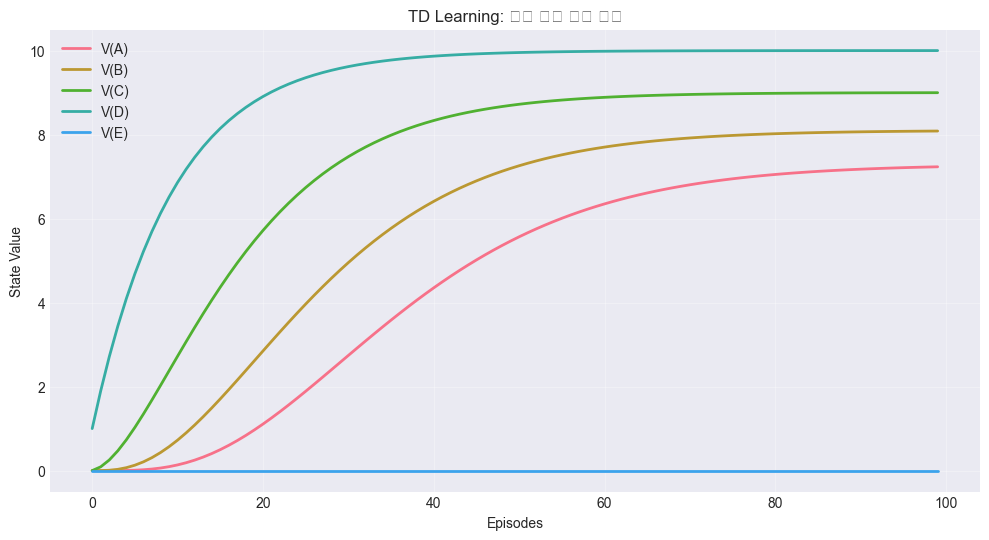

최종 상태 가치:
V(A) = 7.23
V(B) = 8.08
V(C) = 9.00
V(D) = 10.00
V(E) = 0.00


In [3]:
class TDAgent:
    """기본 TD 학습 에이전트"""
    
    def __init__(self, alpha=0.1, gamma=0.99):
        self.alpha = alpha  # 학습률
        self.gamma = gamma  # 할인 인자
        self.V = defaultdict(float)  # 상태 가치 함수
        self.returns = defaultdict(list)  # 에피소드별 리턴
    
    def update(self, state, reward, next_state):
        """TD(0) 업데이트"""
        td_error = reward + self.gamma * self.V[next_state] - self.V[state]
        self.V[state] += self.alpha * td_error
        return td_error

# TD 학습 데모
def demonstrate_td_learning():
    """TD 학습 과정 시각화"""
    agent = TDAgent(alpha=0.1, gamma=0.9)
    
    # 간단한 체인 환경 (1D)
    states = ['A', 'B', 'C', 'D', 'E']
    rewards = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 10}
    
    # 여러 에피소드 시뮬레이션
    history = {s: [] for s in states}
    
    for episode in range(100):
        # 랜덤 시작
        path = ['A', 'B', 'C', 'D', 'E']
        
        for i in range(len(path)-1):
            state = path[i]
            next_state = path[i+1]
            reward = rewards[next_state]
            
            agent.update(state, reward, next_state)
        
        # 기록
        for s in states:
            history[s].append(agent.V[s])
    
    # 시각화
    plt.figure(figsize=(12, 6))
    
    for s in states:
        plt.plot(history[s], label=f'V({s})', linewidth=2)
    
    plt.xlabel('Episodes')
    plt.ylabel('State Value')
    plt.title('TD Learning: 상태 가치 함수 수렴')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("최종 상태 가치:")
    for s in states:
        print(f"V({s}) = {agent.V[s]:.2f}")

demonstrate_td_learning()

## 4. Q-Learning: Off-policy TD Control

Q-learning은 **off-policy** 알고리즘으로, 행동 정책과 무관하게 최적 Q 함수를 학습합니다.

### Q-Learning 업데이트 규칙
$$Q(s,a) \leftarrow Q(s,a) + \alpha[r + \gamma \max_{a'} Q(s',a') - Q(s,a)]$$

### 특징
- **Off-policy**: 탐색 정책과 무관하게 최적 정책 학습
- **Max operator**: 다음 상태에서 최대 Q값 사용
- **수렴 보장**: 적절한 조건 하에서 Q* 수렴

In [5]:
class QLearningAgent:
    """Q-Learning 에이전트"""
    
    def __init__(self, n_actions=4, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(n_actions))
        
        # 학습 기록
        self.episode_rewards = []
        self.episode_lengths = []
        self.td_errors = []
    
    def get_action(self, state, training=True):
        """ε-greedy 행동 선택"""
        if training and random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            q_values = self.Q[state]
            # 동점일 때 랜덤 선택
            max_q = np.max(q_values)
            actions = np.where(q_values == max_q)[0]
            return np.random.choice(actions)
    
    def update(self, state, action, reward, next_state, done):
        """Q-learning 업데이트"""
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.Q[next_state])
        
        td_error = target - self.Q[state][action]
        self.Q[state][action] += self.alpha * td_error
        
        self.td_errors.append(abs(td_error))
        return td_error
    
    def train_episode(self, env):
        """한 에피소드 학습"""
        state = env.reset()
        total_reward = 0
        steps = 0
        
        while True:
            action = self.get_action(state)
            next_state, reward, done, _ = env.step(Action(action))
            
            self.update(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward
            steps += 1
            
            if done:
                break
        
        self.episode_rewards.append(total_reward)
        self.episode_lengths.append(steps)
        
        return total_reward, steps

# Q-Learning 학습
def train_qlearning(env_type='simple', n_episodes=500):
    env = MazeEnv(env_type)
    agent = QLearningAgent(n_actions=4, alpha=0.1, gamma=0.99, epsilon=0.1)
    
    print(f"Q-Learning 학습 시작 ({env_type} maze)...")
    
    for episode in tqdm(range(n_episodes)):
        reward, steps = agent.train_episode(env)
        
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(agent.episode_rewards[-100:])
            avg_steps = np.mean(agent.episode_lengths[-100:])
            print(f"Episode {episode+1}: 평균 보상 = {avg_reward:.2f}, 평균 스텝 = {avg_steps:.1f}")
    
    return agent, env

# 학습 실행
q_agent, q_env = train_qlearning('simple', n_episodes=500)

Q-Learning 학습 시작 (simple maze)...


100%|██████████| 500/500 [00:00<00:00, 7405.22it/s]

Episode 100: 평균 보상 = 86.42, 평균 스텝 = 14.6
Episode 200: 평균 보상 = 91.95, 평균 스텝 = 9.1
Episode 300: 평균 보상 = 91.96, 평균 스텝 = 9.0
Episode 400: 평균 보상 = 92.05, 평균 스텝 = 8.9
Episode 500: 평균 보상 = 92.20, 평균 스텝 = 8.8


## 5. SARSA: On-policy TD Control

SARSA는 **on-policy** 알고리즘으로, 실제 따르는 정책을 학습합니다.

### SARSA 업데이트 규칙
$$Q(s,a) \leftarrow Q(s,a) + \alpha[r + \gamma Q(s',a') - Q(s,a)]$$

### 특징
- **On-policy**: 실제 행동 정책을 학습
- **더 안전한 학습**: 탐색 중 위험 회피
- **이름 유래**: State-Action-Reward-State-Action

In [6]:
class SARSAAgent:
    """SARSA 에이전트"""
    
    def __init__(self, n_actions=4, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(n_actions))
        
        # 학습 기록
        self.episode_rewards = []
        self.episode_lengths = []
        self.td_errors = []
    
    def get_action(self, state, training=True):
        """ε-greedy 행동 선택"""
        if training and random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            q_values = self.Q[state]
            max_q = np.max(q_values)
            actions = np.where(q_values == max_q)[0]
            return np.random.choice(actions)
    
    def update(self, state, action, reward, next_state, next_action, done):
        """SARSA 업데이트"""
        if done:
            target = reward
        else:
            target = reward + self.gamma * self.Q[next_state][next_action]
        
        td_error = target - self.Q[state][action]
        self.Q[state][action] += self.alpha * td_error
        
        self.td_errors.append(abs(td_error))
        return td_error
    
    def train_episode(self, env):
        """한 에피소드 학습"""
        state = env.reset()
        action = self.get_action(state)
        total_reward = 0
        steps = 0
        
        while True:
            next_state, reward, done, _ = env.step(Action(action))
            next_action = self.get_action(next_state)
            
            self.update(state, action, reward, next_state, next_action, done)
            
            state = next_state
            action = next_action
            total_reward += reward
            steps += 1
            
            if done:
                break
        
        self.episode_rewards.append(total_reward)
        self.episode_lengths.append(steps)
        
        return total_reward, steps

# SARSA 학습
def train_sarsa(env_type='simple', n_episodes=500):
    env = MazeEnv(env_type)
    agent = SARSAAgent(n_actions=4, alpha=0.1, gamma=0.99, epsilon=0.1)
    
    print(f"SARSA 학습 시작 ({env_type} maze)...")
    
    for episode in tqdm(range(n_episodes)):
        reward, steps = agent.train_episode(env)
        
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(agent.episode_rewards[-100:])
            avg_steps = np.mean(agent.episode_lengths[-100:])
            print(f"Episode {episode+1}: 평균 보상 = {avg_reward:.2f}, 평균 스텝 = {avg_steps:.1f}")
    
    return agent, env

# 학습 실행
sarsa_agent, sarsa_env = train_sarsa('simple', n_episodes=500)

SARSA 학습 시작 (simple maze)...


100%|██████████| 500/500 [00:00<00:00, 11263.08it/s]

Episode 100: 평균 보상 = 85.01, 평균 스텝 = 15.0
Episode 200: 평균 보상 = 92.15, 평균 스텝 = 8.8
Episode 300: 평균 보상 = 92.30, 평균 스텝 = 8.7
Episode 400: 평균 보상 = 92.11, 평균 스텝 = 8.9
Episode 500: 평균 보상 = 92.15, 평균 스텝 = 8.8


## 6. Q-Learning vs SARSA 비교

두 알고리즘의 차이를 실험적으로 비교해봅시다.

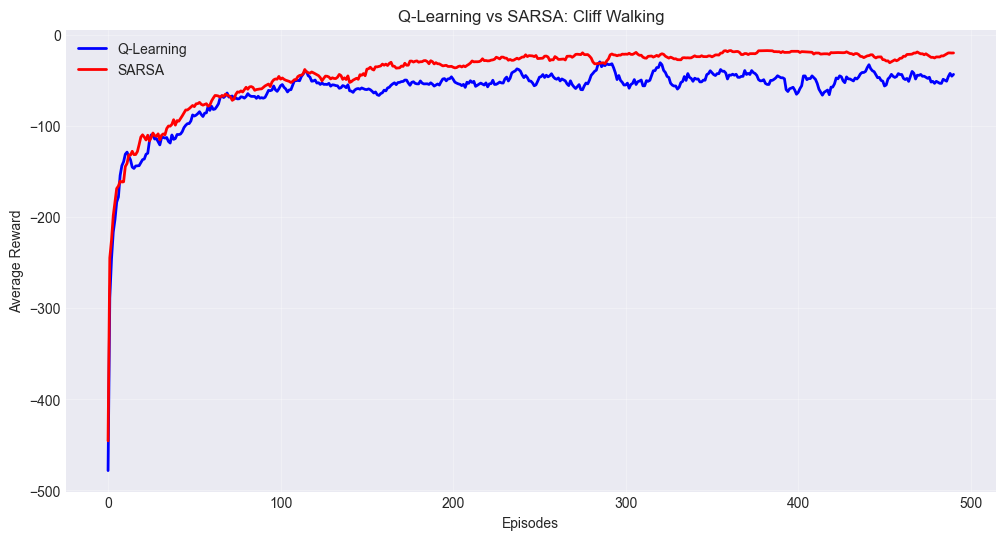


분석 결과:
Q-Learning 최종 평균 보상: -47.82
SARSA 최종 평균 보상: -23.54

💡 인사이트:
- Q-Learning은 최적 경로를 학습 (절벽 가장자리)
- SARSA는 안전한 경로를 학습 (절벽에서 멀리)
- On-policy vs Off-policy의 차이를 보여줌


In [7]:
def compare_algorithms():
    """Q-Learning과 SARSA 성능 비교"""
    
    # 위험한 환경 생성 (절벽 걷기)
    class CliffWalkingEnv:
        def __init__(self):
            self.width = 12
            self.height = 4
            self.start = (3, 0)
            self.goal = (3, 11)
            self.agent_pos = self.start
            self.cliff = [(3, x) for x in range(1, 11)]  # 절벽 위치
        
        def reset(self):
            self.agent_pos = self.start
            return self.agent_pos
        
        def step(self, action):
            y, x = self.agent_pos
            
            if action == Action.UP:
                y = max(0, y - 1)
            elif action == Action.DOWN:
                y = min(self.height - 1, y + 1)
            elif action == Action.LEFT:
                x = max(0, x - 1)
            elif action == Action.RIGHT:
                x = min(self.width - 1, x + 1)
            
            self.agent_pos = (y, x)
            
            # 보상 계산
            if self.agent_pos in self.cliff:
                reward = -100
                self.agent_pos = self.start  # 떨어지면 시작점으로
                done = False
            elif self.agent_pos == self.goal:
                reward = 0
                done = True
            else:
                reward = -1
                done = False
            
            return self.agent_pos, reward, done, {}
    
    # 두 알고리즘으로 학습
    n_episodes = 500
    n_runs = 10
    
    q_rewards_all = []
    sarsa_rewards_all = []
    
    for run in range(n_runs):
        # Q-Learning
        env = CliffWalkingEnv()
        q_agent = QLearningAgent(n_actions=4, alpha=0.1, gamma=0.99, epsilon=0.1)
        
        for episode in range(n_episodes):
            state = env.reset()
            total_reward = 0
            
            while True:
                action = q_agent.get_action(state)
                next_state, reward, done, _ = env.step(Action(action))
                q_agent.update(state, action, reward, next_state, done)
                
                state = next_state
                total_reward += reward
                
                if done:
                    break
            
            q_agent.episode_rewards.append(total_reward)
        
        q_rewards_all.append(q_agent.episode_rewards)
        
        # SARSA
        env = CliffWalkingEnv()
        sarsa_agent = SARSAAgent(n_actions=4, alpha=0.1, gamma=0.99, epsilon=0.1)
        
        for episode in range(n_episodes):
            state = env.reset()
            action = sarsa_agent.get_action(state)
            total_reward = 0
            
            while True:
                next_state, reward, done, _ = env.step(Action(action))
                next_action = sarsa_agent.get_action(next_state)
                sarsa_agent.update(state, action, reward, next_state, next_action, done)
                
                state = next_state
                action = next_action
                total_reward += reward
                
                if done:
                    break
            
            sarsa_agent.episode_rewards.append(total_reward)
        
        sarsa_rewards_all.append(sarsa_agent.episode_rewards)
    
    # 평균 계산
    q_rewards_mean = np.mean(q_rewards_all, axis=0)
    sarsa_rewards_mean = np.mean(sarsa_rewards_all, axis=0)
    
    # 시각화
    plt.figure(figsize=(12, 6))
    
    # 이동 평균 계산 (window=10)
    window = 10
    q_smooth = np.convolve(q_rewards_mean, np.ones(window)/window, mode='valid')
    sarsa_smooth = np.convolve(sarsa_rewards_mean, np.ones(window)/window, mode='valid')
    
    plt.plot(q_smooth, label='Q-Learning', linewidth=2, color='blue')
    plt.plot(sarsa_smooth, label='SARSA', linewidth=2, color='red')
    
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.title('Q-Learning vs SARSA: Cliff Walking')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("\n분석 결과:")
    print(f"Q-Learning 최종 평균 보상: {np.mean(q_rewards_mean[-50:]):.2f}")
    print(f"SARSA 최종 평균 보상: {np.mean(sarsa_rewards_mean[-50:]):.2f}")
    print("\n💡 인사이트:")
    print("- Q-Learning은 최적 경로를 학습 (절벽 가장자리)")
    print("- SARSA는 안전한 경로를 학습 (절벽에서 멀리)")
    print("- On-policy vs Off-policy의 차이를 보여줌")

compare_algorithms()

## 7. N-step TD와 TD(λ)

### N-step TD
한 스텝이 아닌 N 스텝 앞을 보고 업데이트:
$$G_t^{(n)} = r_{t+1} + \gamma r_{t+2} + ... + \gamma^{n-1} r_{t+n} + \gamma^n V(s_{t+n})$$

### TD(λ)
모든 n-step 리턴의 가중 평균:
$$G_t^\lambda = (1-\lambda) \sum_{n=1}^\infty \lambda^{n-1} G_t^{(n)}$$


Training 1-step Q-Learning...


100%|██████████| 300/300 [00:00<00:00, 12909.79it/s]



Training 3-step Q-Learning...


100%|██████████| 300/300 [00:00<00:00, 12841.93it/s]



Training 5-step Q-Learning...


100%|██████████| 300/300 [00:00<00:00, 14472.43it/s]



Training 10-step Q-Learning...


100%|██████████| 300/300 [00:00<00:00, 16826.35it/s]
/Users/gd452/Development/my-llm-lab/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gd452/Development/my-llm-lab/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


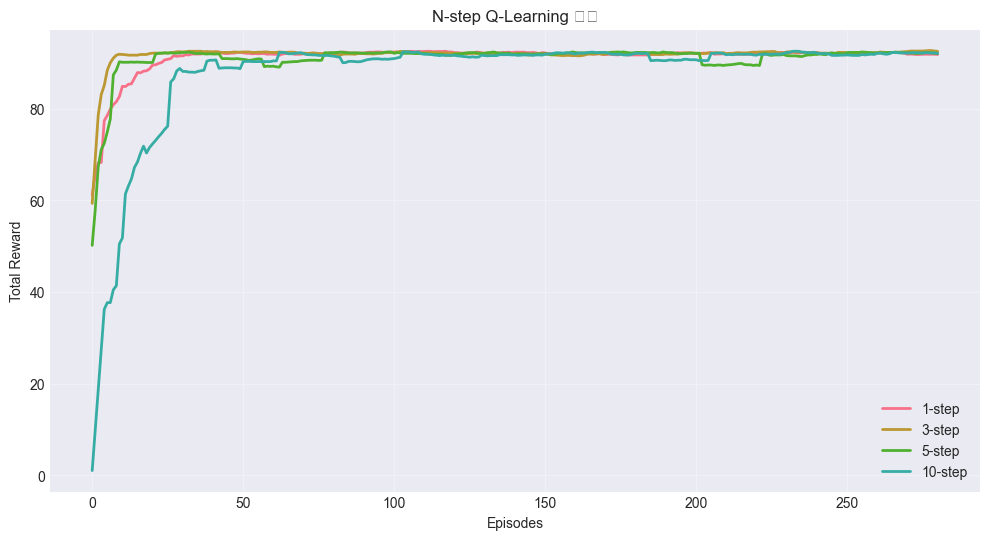


💡 N-step 효과:
- N=1: 기본 Q-learning (빠른 업데이트, 높은 분산)
- N=3-5: 균형잡힌 성능
- N=10: Monte Carlo에 가까움 (느린 업데이트, 낮은 분산)


In [8]:
class NStepQLearning:
    """N-step Q-Learning"""
    
    def __init__(self, n_actions=4, n_steps=3, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.n_actions = n_actions
        self.n_steps = n_steps
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(n_actions))
        
        # N-step 버퍼
        self.state_buffer = deque(maxlen=n_steps)
        self.action_buffer = deque(maxlen=n_steps)
        self.reward_buffer = deque(maxlen=n_steps)
    
    def get_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            return np.argmax(self.Q[state])
    
    def update(self, done=False, next_state=None):
        """N-step 업데이트"""
        if len(self.state_buffer) < self.n_steps and not done:
            return
        
        # N-step 리턴 계산
        G = 0
        for i in range(len(self.reward_buffer)):
            G += (self.gamma ** i) * self.reward_buffer[i]
        
        if not done and next_state is not None:
            G += (self.gamma ** len(self.reward_buffer)) * np.max(self.Q[next_state])
        
        # 첫 번째 상태-행동 쌍 업데이트
        state = self.state_buffer[0]
        action = self.action_buffer[0]
        
        td_error = G - self.Q[state][action]
        self.Q[state][action] += self.alpha * td_error
    
    def train_episode(self, env):
        state = env.reset()
        total_reward = 0
        
        # 버퍼 초기화
        self.state_buffer.clear()
        self.action_buffer.clear()
        self.reward_buffer.clear()
        
        while True:
            action = self.get_action(state)
            next_state, reward, done, _ = env.step(Action(action))
            
            # 버퍼에 추가
            self.state_buffer.append(state)
            self.action_buffer.append(action)
            self.reward_buffer.append(reward)
            
            # N-step 업데이트
            self.update(done, next_state)
            
            state = next_state
            total_reward += reward
            
            if done:
                # 남은 버퍼 처리
                while len(self.state_buffer) > 0:
                    self.update(done=True)
                    self.state_buffer.popleft()
                    self.action_buffer.popleft()
                    self.reward_buffer.popleft()
                break
        
        return total_reward

# N-step 비교 실험
def compare_n_steps():
    """다양한 N 값 비교"""
    n_values = [1, 3, 5, 10]
    results = {}
    
    for n in n_values:
        env = MazeEnv('simple')
        agent = NStepQLearning(n_steps=n)
        rewards = []
        
        print(f"\nTraining {n}-step Q-Learning...")
        for episode in tqdm(range(300)):
            reward = agent.train_episode(env)
            rewards.append(reward)
        
        results[n] = rewards
    
    # 시각화
    plt.figure(figsize=(12, 6))
    
    for n in n_values:
        # 이동 평균
        window = 20
        smooth = np.convolve(results[n], np.ones(window)/window, mode='valid')
        plt.plot(smooth, label=f'{n}-step', linewidth=2)
    
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('N-step Q-Learning 비교')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("\n💡 N-step 효과:")
    print("- N=1: 기본 Q-learning (빠른 업데이트, 높은 분산)")
    print("- N=3-5: 균형잡힌 성능")
    print("- N=10: Monte Carlo에 가까움 (느린 업데이트, 낮은 분산)")

compare_n_steps()

## 8. 실전 적용: 열쇠-문 미로 해결

복잡한 열쇠-문 미로를 Q-learning으로 해결해봅시다.

복잡한 열쇠-문 미로 학습...


100%|██████████| 1000/1000 [00:00<00:00, 7748.98it/s]
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_70975/142005104.py:104: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_70975/142005104.py:104: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_70975/142005104.py:104: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_70975/142005104.py:104: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_70975/142005104.py:104: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy

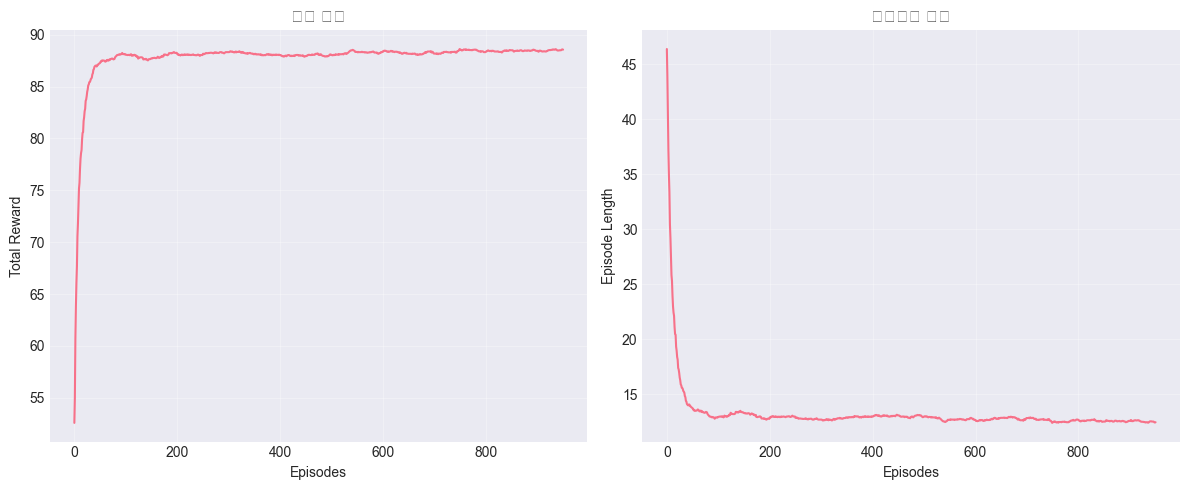


Q 값 히트맵:


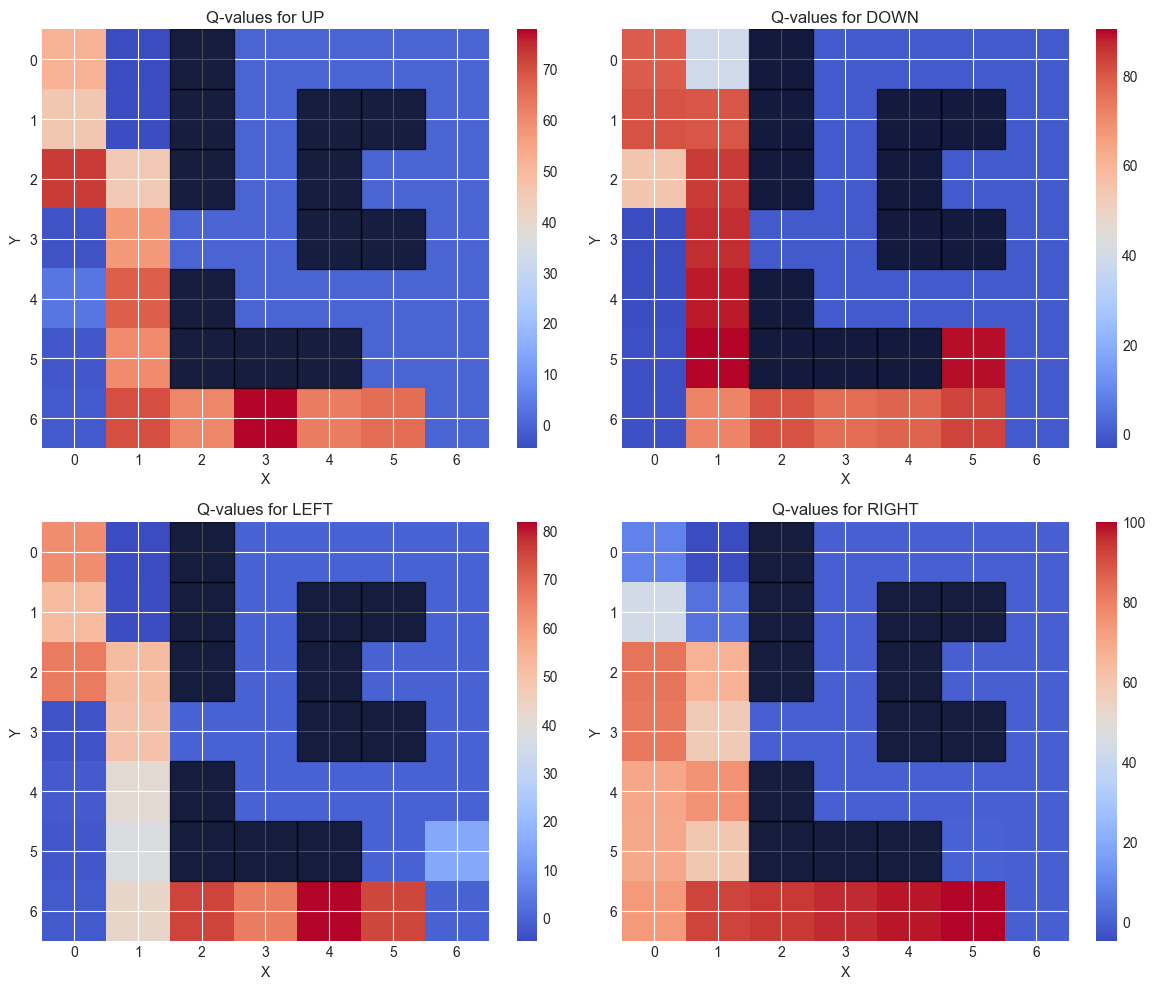


에피소드 1 경로:
State: (0, 0, 0), Action: DOWN
State: (1, 0, 0), Action: DOWN
State: (2, 0, 0), Action: RIGHT
State: (2, 1, 0), Action: DOWN
State: (3, 1, 0), Action: DOWN
State: (4, 1, 0), Action: DOWN
State: (5, 1, 0), Action: DOWN
State: (6, 1, 0), Action: RIGHT
State: (6, 2, 0), Action: RIGHT
State: (6, 3, 0), Action: RIGHT
State: (6, 4, 0), Action: RIGHT
State: (6, 5, 0), Action: RIGHT

테스트 결과:
성공률: 100.0%
평균 스텝: 12.0


(100.0, 12.0)

In [9]:
def visualize_q_values(agent, env):
    """Q 값 시각화"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    action_names = ['UP', 'DOWN', 'LEFT', 'RIGHT']
    
    for action_idx, (ax, action_name) in enumerate(zip(axes.flat, action_names)):
        q_grid = np.zeros((env.height, env.width))
        
        for y in range(env.height):
            for x in range(env.width):
                state = (y, x, 0)  # 열쇠 없는 상태
                q_grid[y, x] = agent.Q[state][action_idx]
        
        im = ax.imshow(q_grid, cmap='coolwarm', aspect='auto')
        ax.set_title(f'Q-values for {action_name}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        plt.colorbar(im, ax=ax)
        
        # 벽 표시
        for y in range(env.height):
            for x in range(env.width):
                if env.maze[y][x] == '#':
                    ax.add_patch(plt.Rectangle((x-0.5, y-0.5), 1, 1, 
                                              fill=True, color='black', alpha=0.7))
    
    plt.tight_layout()
    plt.show()

def test_agent(agent, env, n_episodes=10, visualize=False):
    """학습된 에이전트 테스트"""
    success_count = 0
    total_steps = 0
    
    for episode in range(n_episodes):
        state = env.reset()
        steps = 0
        path = []
        
        while steps < env.max_steps:
            action = agent.get_action(state, training=False)
            path.append((state, Action(action)))
            
            state, reward, done, _ = env.step(Action(action))
            steps += 1
            
            if done:
                if env.agent_pos == env.goal:
                    success_count += 1
                break
        
        total_steps += steps
        
        if visualize and episode == 0:
            print(f"\n에피소드 {episode+1} 경로:")
            env.reset()
            for state, action in path[:20]:  # 처음 20스텝만
                print(f"State: {state}, Action: {action.name}")
    
    success_rate = success_count / n_episodes * 100
    avg_steps = total_steps / n_episodes
    
    print(f"\n테스트 결과:")
    print(f"성공률: {success_rate:.1f}%")
    print(f"평균 스텝: {avg_steps:.1f}")
    
    return success_rate, avg_steps

# 열쇠-문 미로 학습
print("복잡한 열쇠-문 미로 학습...")
complex_env = MazeEnv('key_door')
complex_agent = QLearningAgent(n_actions=4, alpha=0.1, gamma=0.99, epsilon=0.1)

# 학습
for episode in tqdm(range(1000)):
    complex_agent.train_episode(complex_env)
    
    # Epsilon decay
    if episode % 100 == 0:
        complex_agent.epsilon *= 0.9

# 학습 곡선
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
window = 50
rewards_smooth = np.convolve(complex_agent.episode_rewards, 
                             np.ones(window)/window, mode='valid')
plt.plot(rewards_smooth)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('학습 곡선')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
steps_smooth = np.convolve(complex_agent.episode_lengths, 
                          np.ones(window)/window, mode='valid')
plt.plot(steps_smooth)
plt.xlabel('Episodes')
plt.ylabel('Episode Length')
plt.title('에피소드 길이')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Q 값 시각화
print("\nQ 값 히트맵:")
visualize_q_values(complex_agent, complex_env)

# 테스트
test_agent(complex_agent, complex_env, n_episodes=20, visualize=True)

## 9. 고급 기법: Double Q-Learning

Q-learning의 과대평가(overestimation) 문제를 해결하는 Double Q-Learning을 구현합니다.

학습 중...


100%|██████████| 500/500 [00:00<00:00, 5610.42it/s]
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_70975/2195355075.py:122: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_70975/2195355075.py:122: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_70975/2195355075.py:122: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_70975/2195355075.py:122: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_70975/2195355075.py:122: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2d/g5tj3tv9

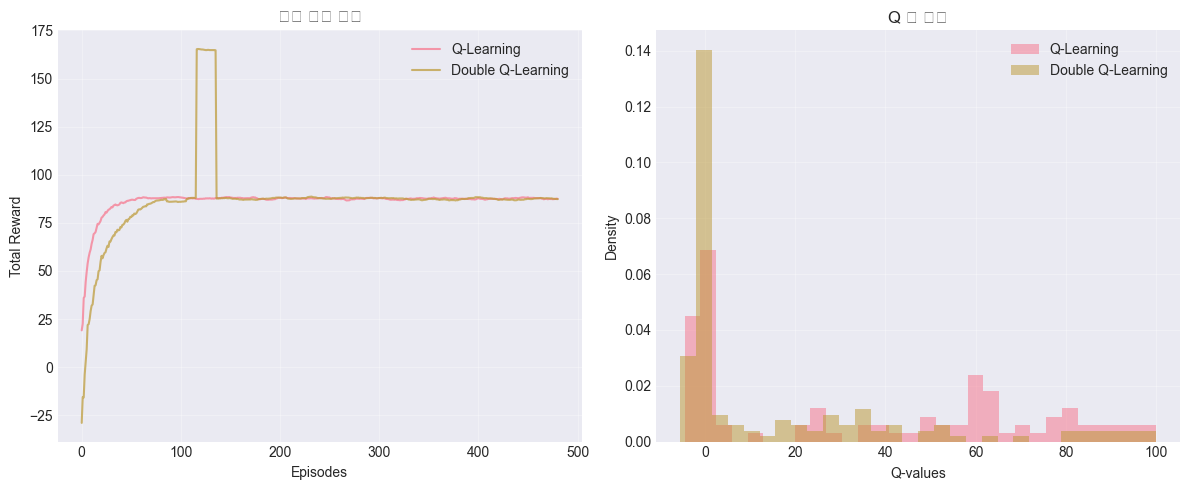


💡 Double Q-Learning 효과:
- 과대평가(overestimation) 감소
- 더 안정적인 학습
- Q 값 분산 감소


In [10]:
class DoubleQLearning:
    """Double Q-Learning 에이전트"""
    
    def __init__(self, n_actions=4, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        
        # 두 개의 Q 함수
        self.Q1 = defaultdict(lambda: np.zeros(n_actions))
        self.Q2 = defaultdict(lambda: np.zeros(n_actions))
        
        self.episode_rewards = []
    
    def get_action(self, state, training=True):
        """평균 Q 값으로 행동 선택"""
        if training and random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            # 두 Q 함수의 평균 사용
            q_values = (self.Q1[state] + self.Q2[state]) / 2
            return np.argmax(q_values)
    
    def update(self, state, action, reward, next_state, done):
        """Double Q-learning 업데이트"""
        # 50% 확률로 Q1 또는 Q2 업데이트
        if random.random() < 0.5:
            # Q1 업데이트
            if done:
                target = reward
            else:
                # Q1으로 행동 선택, Q2로 평가
                best_action = np.argmax(self.Q1[next_state])
                target = reward + self.gamma * self.Q2[next_state][best_action]
            
            td_error = target - self.Q1[state][action]
            self.Q1[state][action] += self.alpha * td_error
        else:
            # Q2 업데이트
            if done:
                target = reward
            else:
                # Q2로 행동 선택, Q1으로 평가
                best_action = np.argmax(self.Q2[next_state])
                target = reward + self.gamma * self.Q1[next_state][best_action]
            
            td_error = target - self.Q2[state][action]
            self.Q2[state][action] += self.alpha * td_error
    
    def train_episode(self, env):
        state = env.reset()
        total_reward = 0
        
        while True:
            action = self.get_action(state)
            next_state, reward, done, _ = env.step(Action(action))
            
            self.update(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward
            
            if done:
                break
        
        self.episode_rewards.append(total_reward)
        return total_reward

# Double Q-Learning vs Q-Learning 비교
def compare_double_q():
    """Double Q-Learning 효과 비교"""
    env_q = MazeEnv('key_door')
    env_double = MazeEnv('key_door')
    
    q_agent = QLearningAgent()
    double_agent = DoubleQLearning()
    
    n_episodes = 500
    
    print("학습 중...")
    for episode in tqdm(range(n_episodes)):
        q_agent.train_episode(env_q)
        double_agent.train_episode(env_double)
    
    # 시각화
    plt.figure(figsize=(12, 5))
    
    window = 20
    
    plt.subplot(1, 2, 1)
    q_smooth = np.convolve(q_agent.episode_rewards, np.ones(window)/window, mode='valid')
    double_smooth = np.convolve(double_agent.episode_rewards, np.ones(window)/window, mode='valid')
    
    plt.plot(q_smooth, label='Q-Learning', alpha=0.7)
    plt.plot(double_smooth, label='Double Q-Learning', alpha=0.7)
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('학습 성능 비교')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    # Q 값 분산 비교
    q_values = []
    double_values = []
    
    for state in q_agent.Q.keys():
        q_values.extend(q_agent.Q[state])
    
    for state in double_agent.Q1.keys():
        double_values.extend((double_agent.Q1[state] + double_agent.Q2[state]) / 2)
    
    plt.hist(q_values, bins=30, alpha=0.5, label='Q-Learning', density=True)
    plt.hist(double_values, bins=30, alpha=0.5, label='Double Q-Learning', density=True)
    plt.xlabel('Q-values')
    plt.ylabel('Density')
    plt.title('Q 값 분포')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Double Q-Learning 효과:")
    print("- 과대평가(overestimation) 감소")
    print("- 더 안정적인 학습")
    print("- Q 값 분산 감소")

compare_double_q()

## 10. 요약 및 핵심 개념

### 이번 노트북에서 배운 내용

1. **Temporal Difference (TD) 학습**
   - 부트스트래핑: 추정값으로 추정값 업데이트
   - TD error를 통한 온라인 학습

2. **Q-Learning**
   - Off-policy: 최적 정책 직접 학습
   - Max operator 사용
   - 탐색과 무관하게 최적 Q* 수렴

3. **SARSA**
   - On-policy: 실제 따르는 정책 학습
   - 더 안전한 학습 (위험 회피)
   - 실제 행동 고려

4. **고급 기법**
   - N-step TD: 여러 스텝 고려
   - Double Q-Learning: 과대평가 해결
   - ε-greedy 전략과 탐색

### Q-Learning vs SARSA 핵심 차이

| 특성 | Q-Learning | SARSA |
|-----|-----------|--------|
| 정책 유형 | Off-policy | On-policy |
| 업데이트 | max Q(s',a') | Q(s',a') |
| 최적성 | 최적 정책 학습 | 실제 정책 학습 |
| 안전성 | 위험 감수 | 위험 회피 |
| 수렴성 | Q*로 수렴 | 정책의 Q로 수렴 |

### 다음 노트북 예고
**Notebook 3: Deep RL - DQN과 PPO**
- Neural Network + Q-Learning = DQN
- Experience Replay와 Target Network
- Policy Gradient Methods
- PPO: 현대 RL의 주력 알고리즘

In [ ]:
# 학습 체크포인트
print("🎯 학습 완료 체크리스트:")
print("✅ TD 학습 이해")
print("✅ Q-Learning 구현")
print("✅ SARSA 구현")
print("✅ On-policy vs Off-policy 차이 이해")
print("✅ N-step TD 구현")
print("✅ Double Q-Learning 구현")
print("✅ 복잡한 환경에서 에이전트 훈련")
print("\n🚀 다음 단계: Deep Learning과 RL의 결합!")